# Úkol č. 3 - Segmentace zákazníků e-shopu (do 29. listopadu)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
    - Počet dnů počítejte ke dni uskutečnění poslendní transakce v celém datasetu (tj. 12/19/2015), nikoli k dnešku. Tváříme se, že jde o aktuální data.
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("eshop.csv")

In [ ]:
df.head()

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Ke komentování toho, co v notebooku děláte, použijte Markdown buňky.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni
  


## Podpůrné proměnné a funkce

In [5]:
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
import collections, numpy

#plt.rcParams['figure.figsize'] = [15, 10]
plt.rc('figure',figsize = [15, 10])
plt.rc('axes', titlesize=20)  
plt.rc('axes', labelsize=18)

LABEL_COLOR_MAP = {0 : 'r', 1 : 'g', 2 : 'b', 3 : 'c', 4 : 'm', 5 : 'y', 6 : 'k'}
INT_MAX = 2147483647

def myNorm(X):
    myMaxes = [0 for i in range(len(X[0]))]
    for item in X:
        for i in range(len(item)):
            if item[i] > myMaxes[i]:
                myMaxes[i] = item[i]

    for j in range(len(X)):
        for i in range(len(X[j])):
            X[j][i] /= float(myMaxes[i])

    return X

## Načtení a zpracování dat
Načtení dat ze souboru a vyextrahování RMF příznaků z dat. Jak bonusové tak nebonusové verze RMF

In [6]:
with open("eshop.csv",'r') as f:
    lines = [line.rstrip('\n') for line in f]

lastDay = datetime.datetime(2015,12,19)
matrix = {} #ID customer, diff between last date and date of an sale, price of an sale
for line in lines[1:]:
    tmp = line.split(',')
    tmpDate = tmp[1].split('/')
    time1 = datetime.datetime(int(tmpDate[2]),int(tmpDate[0]),int(tmpDate[1]))
    diffDays = (lastDay-time1).days

    if int(tmp[0]) not in matrix.keys():
        matrix[int(tmp[0])] = [[diffDays,float(tmp[2])]]
    else:
        matrix[int(tmp[0])].append([diffDays,float(tmp[2])])

uniqueIDList = list(matrix.keys())

#každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
rmfDataFrame = [[] for i in range(len(uniqueIDList))]
rmfDataFrameBonus = [[] for i in range(len(uniqueIDList))]

# Recency
# nebonus -> Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
# bonus -> maximum počtu měsíců od posledního nákupu a čísla 1
for cnt, ID in enumerate(uniqueIDList):
    nebonus = INT_MAX
    bonus = INT_MAX
    for order in matrix[ID]:
        if order[0] < nebonus:
            nebonus = order[0]
        if order[0]//30 < bonus:
            bonus = order[0]//30
    bonus = max(bonus,1)
    rmfDataFrame[cnt].append(nebonus)
    rmfDataFrameBonus[cnt].append(bonus)

# Frequency
# nebonus -> Počet nákupů.
# bonus -> maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1
for cnt, ID in enumerate(uniqueIDList):
    nebonus = 0
    bonus = 0
    for order in matrix[ID]:
        nebonus += 1
        if order[0] <= 365:
            bonus += 1
    bonus = max(bonus,1)
    rmfDataFrame[cnt].append(nebonus)
    rmfDataFrameBonus[cnt].append(bonus)

# Monetary
# nebonus -> Celková suma, kterou daný zákazník utratil.
# bonus -> Nejvyšší hodnota nákupu daného zákazníka
for cnt, ID in enumerate(uniqueIDList):
    nebonus = 0.0
    bonus = -1
    for order in matrix[ID]:
        nebonus += order[1]
        if order[1] > bonus:
            bonus = order[1]
    bonus = max(bonus,1)
    rmfDataFrame[cnt].append(nebonus)
    rmfDataFrameBonus[cnt].append(bonus)


rmfDataFrame = np.array(rmfDataFrame)
rmfDataFrameBonus = np.array(rmfDataFrameBonus)

## Ukázka dat
Nyní si ukážeme rmf body ve 3D prostoru s aplikací k-means (k=3) na data s nebonusovými RMF příznaky.

Counter({0: 4740, 1: 4588, 2: 3501})


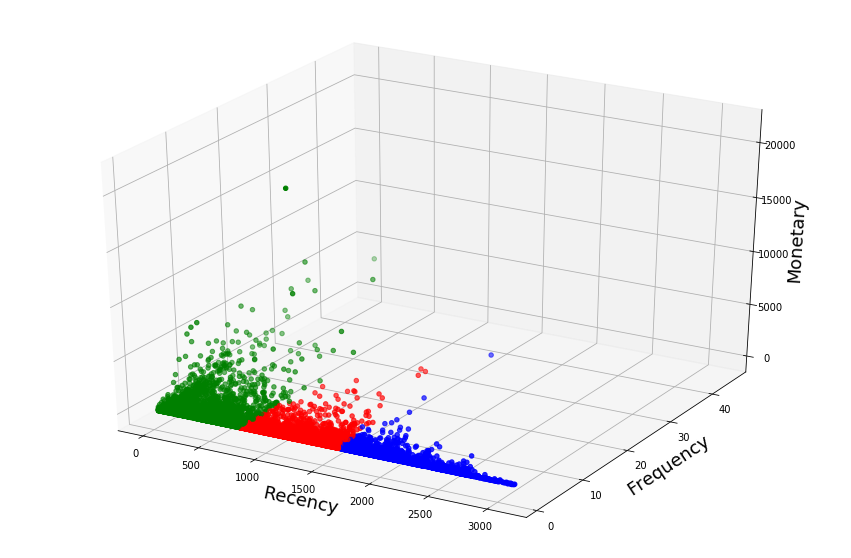

In [7]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(rmfDataFrame)
print(collections.Counter(kmeans.labels_))
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(rmfDataFrame[:,0],rmfDataFrame[:,1],rmfDataFrame[:,2],color=label_color)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.show()

Vidíme, že jelikož jsou body nepřeškálované, tak mají některé dimenze větši vliv než ostatní (kvůli tomu, že clustery určujeme podle vzdálenosti). Proto normalizujeme body podle příznaků tak, aby byl každý příznak rmf bodu mezi [0-1].

Counter({2: 4706, 0: 4631, 1: 3492})


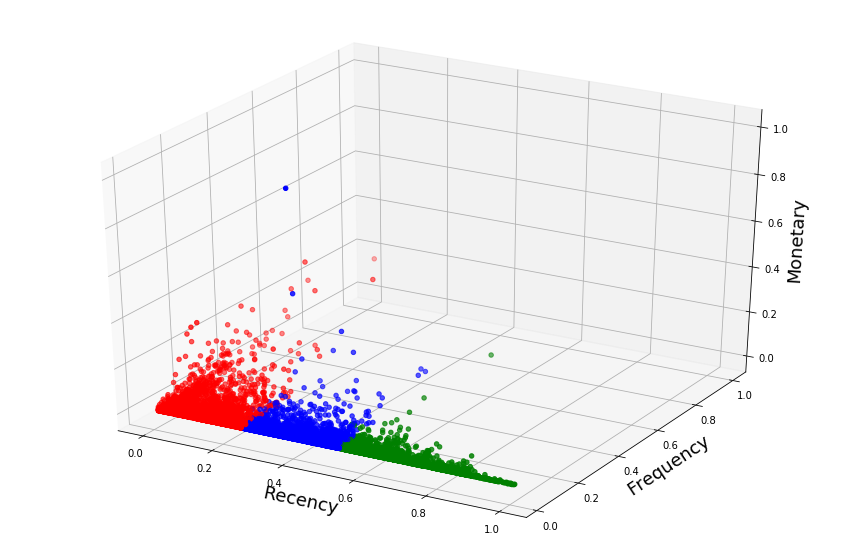

In [8]:
rmfDataFrame = myNorm(rmfDataFrame)
rmfDataFrameBonus = myNorm(rmfDataFrameBonus)
kmeans = KMeans(n_clusters=3, random_state=0).fit(rmfDataFrame)
print(collections.Counter(kmeans.labels_))
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(rmfDataFrame[:,0],rmfDataFrame[:,1],rmfDataFrame[:,2],color=label_color)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.show()

## Hledání počtu clusterů
Jelikož máme data dimenze 3, můžeme si data a jednotlivé clustery vizualizovat a výsledný počet clusterů můžeme určit odhadem, kdy se nám bude zdát, že je splněna podmínka kdy blízké body budou ve stejném shluku a zároveň vzdálené body budou v různých shlucích. Častým způsobem určení k je hledání tzv. loket (angl. elbow) neboli místa grafu účelové funkce pro kterou se mění pokles účelové funkce z hodně prudkého na méně prudký. V našem případě použijeme jako účelovou funkci tzv. Silhouette hodnotu.

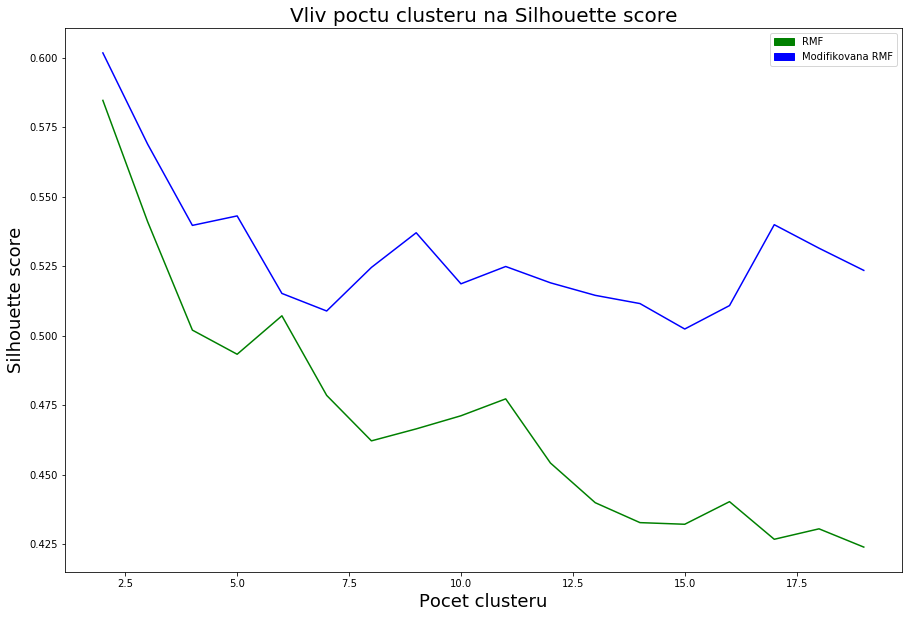

In [9]:
from sklearn.metrics import silhouette_score
X, Y, YBonus = [], [], []
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(rmfDataFrame)
    kmeansBonus = KMeans(n_clusters=i, random_state=0).fit(rmfDataFrameBonus)
    score = silhouette_score(rmfDataFrame,kmeans.labels_)
    scoreBonus = silhouette_score(rmfDataFrameBonus,kmeansBonus.labels_)
    X.append(i)
    Y.append(score)
    YBonus.append(scoreBonus)

plt.plot(X,Y,color='green')
plt.plot(X,YBonus,color='blue')
plt.xlabel('Pocet clusteru')
plt.ylabel('Silhouette score')
plt.title('Vliv poctu clusteru na Silhouette score')
patchesList = []
patchesList.append(mpatches.Patch(color='green', label='RMF'))
patchesList.append(mpatches.Patch(color='blue', label='Modifikovana RMF'))
plt.legend(handles=patchesList)
plt.show()

## Hledání počtu clusterů
Subjektivně řeknu, že tzv. loket nastáva když je k = 4. V našem případě nám tato metoda moc nepomohla, jelikož výsledné počet clusterů byl příliš malý odlišení superstar zákazníků. Nakonec jsem přidával k (počinaje od čísla 4), dokud jsem nenašel první číslo, které superstar zákazníky efektivně odlišilo. Došel jsem ke k=7.

## Výsledné clustery
Zobrazení výsledných sedmi clusterů s nebonusovými RMF příznaky. Ve žluté barvě vidíme cluster "superzákazníků" a naopak nejméně zajímaví zakázníci mají tyrkysovou barvu.

Counter({4: 2491, 2: 2405, 0: 2339, 6: 2166, 1: 2072, 3: 1067, 5: 289})


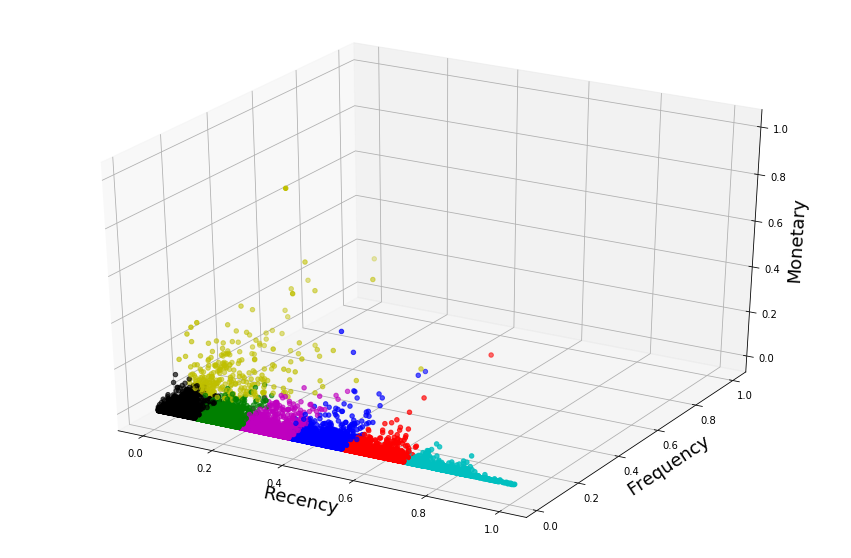

In [10]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(rmfDataFrame)
print(collections.Counter(kmeans.labels_))
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(rmfDataFrame[:,0],rmfDataFrame[:,1],rmfDataFrame[:,2],color=label_color)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.show()

## Výsledné clustery
Zobrazení výsledných sedmi clusterů s bonusovými RMF příznaky. Ve fialové barvě vidíme cluster "superzákazníků" a naopak nejméně zajímaví zakázníci mají modrou barvu.

Counter({0: 2163, 4: 2083, 3: 1974, 5: 1949, 6: 1842, 1: 1776, 2: 1042})


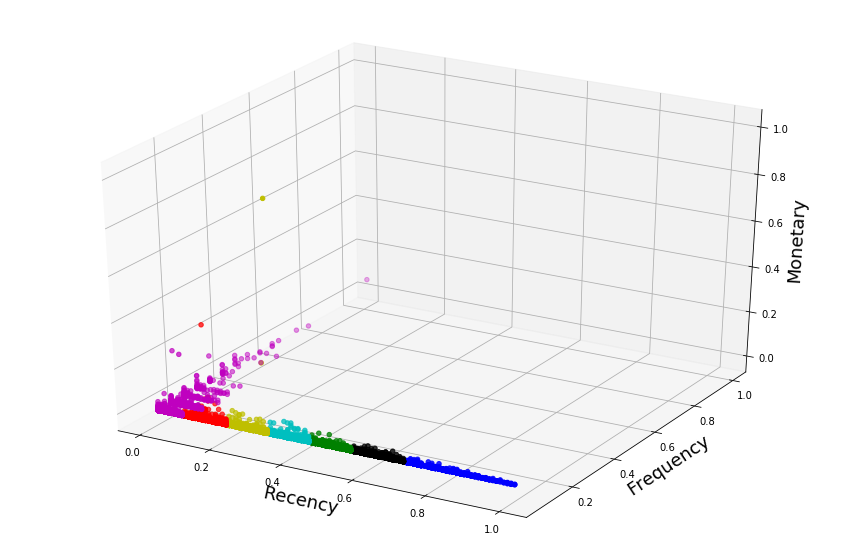

In [11]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(rmfDataFrameBonus)
print(collections.Counter(kmeans.labels_))
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(rmfDataFrameBonus[:,0],rmfDataFrameBonus[:,1],rmfDataFrameBonus[:,2],color=label_color)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.show()

## Porovnání
Oproti nebonusovým příznakům je vidět že mají data s bonusovými RMF příznaky menší rozptyl co se týče Frequency a Monetary.